# __2022 Business Layoffs: An Analysis__
> ## By: William Yang and John Wendlandt

### 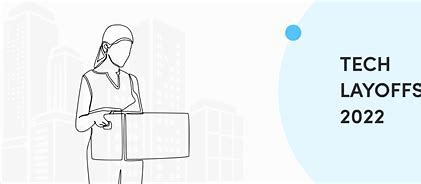

### __Table of Contents__
##### 1. [Data Scraping and Representation](#Data-Scraping-and-Representation)
##### 2. [Data Exploration](#Exploratory-Data-Analysis)
>#####       2.1 [Industry](#INDUSTRY)
>#####       2.2 [Stage](#STAGE)
>#####       2.3 [Date](#DATE)
>#####       2.4 [Location](#LOCATION)
##### 3. [Conclusion](#CONCLUSION)

### Searching for the right job is certainly not an easy process. There are several factors when deciding the company to join. The most popular factors include type of work you will do, pay, location, and benefits. But a new and much more pressing statistic is rising: layoffs. According to [layoffs.fyi](https://layoffs.fyi/), there were more than 140,000 tech workers who were layed off in 2022. It does not help that we currently exist in a very unstable and poor economic climate. It is almost everday now that you hear about a new company laying off hundreds of workers. The most infamous one yet is Elon Musk's and the [Twitter cleansing](https://www.cnbc.com/2022/11/04/twitter-sued-by-employees-after-mass-layoffs-begin.html#:~:text=Twitter%20employees%20are%20expecting%20the%20company%20to%20cut,60%20days%2C%20of%20mass%20layoffs%20or%20plant%20closings.). Thus, our goal in this project is to analyze the layoffs of the top companies in 2022. Not only will we be exploring the amount of workers layed off, but we will also be examining the company's location, stage, and industry. Thus, by the end of this analysis, we will know the safest type of companies to join and hopefully this resource can be utilized for everyone's benefit :)

## Data Scraping and Representation
#### The first steps of this process are to import our necessary libraries and to gather our data into a tabular form. Libararies are an amazing way to utilize code already curated by an author. Python offers many different types of libraries. [Here](https://data-flair.training/blogs/python-libraries/) is a list of helpful data science libaries. We also want tabular data since it is much easier to analyze and plot any trends we see. Luckily,  [layoffs.fyi](https://layoffs.fyi/)  provides 2022 business layoffs in a .csv which is formatted tabularly. Thus, all we need to do is:

In [54]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import warnings

# read in our csv file into a data frame
warnings.filterwarnings("ignore")
data = pd.read_csv("layoffs_data[1].csv")

#### Next, lets take out all the unnecessary columns and filter out missing data. Columns that are not important to our analysis are source, date added, and list of employees laid off. Funds raised is an ambiguous column, so we will be deleting that column as well. Regarding missing data, if neither lay off count or percentage exists, the best course of action would be to delete the row. If only one of those columns exists, we should include the row if either value hits above a certain threshold because then this company has a signifcantly large layoff number/percentage. Thus, we will take the median of laid off count and percentage and include the row if it is larger than that threshold.

In [55]:
# delete any unnecessary columns 
del data["Source"]
del data["Funds_Raised"]
del data["Date_Added"]
del data["List_of_Employees_Laid_Off"]

In [56]:
# find the medians for each column
indexDrop = []
medianLayoff = data["Laid_Off_Count"].median()
medianPercent = data["Percentage"].median()

# drop any rows that do not meet our threshold of > than median
for i, row in data.iterrows():
    if np.isnan(row["Laid_Off_Count"]) and np.isnan(row["Percentage"]):
        indexDrop.append(i)
    if np.isnan(row["Laid_Off_Count"]) and row["Percentage"] < medianPercent:
        indexDrop.append(i)
    if np.isnan(row["Percentage"]) and row["Laid_Off_Count"] < medianLayoff:
        indexDrop.append(i)
data = data.drop(indexDrop)
data.head()

,Company,Location,Industry,Laid_Off_Count,Percentage,Date,Stage,Country
0,Doma,SF Bay Area,Finance,515.0,0.400,2022-12-06,IPO,United States
1,BuzzFeed,New York City,Media,180.0,0.120,2022-12-06,IPO,United States
2,Weedmaps,Los Angeles,Other,175.0,0.250,2022-12-06,Acquired,United States
3,Adobe,SF Bay Area,Marketing,100.0,NaN,2022-12-06,IPO,United States
4,Chipper Cash,SF Bay Area,Finance,50.0,0.125,2022-12-06,Series C,United States


#### The next step in cleaning our data is to make sure there are no duplicate rows. Many companies do not lay off workers all at once. Instead, based on the market and how the company is doing, they will lay off workers in stages. In that case, we must sum up the multiple entries for lay off count and percentage and create a final entry with those sums. Regarding the date, the date will be the entry that layed off the most workers. 

In [57]:
# groupby columns with their sums to take out duplicates and sum their totals
data = data.sort_values(by='Company', ascending = False)
newLayoff = pd.DataFrame(data.groupby('Company')["Laid_Off_Count"].sum())
newPercent = pd.DataFrame(data.groupby('Company')["Percentage"].sum())

# drop all duplicate rows (duplicates being same company)
data = data.drop_duplicates(subset = "Company")

# replace columns with new ones
newLayoff = newLayoff.sort_values(by='Company', ascending = False)
newPercentage = newPercent.sort_values(by='Company', ascending = False)
data["Laid_Off_Count"] = newLayoff["Laid_Off_Count"].values
data["Percentage"] = newPercent["Percentage"].values
data.index = np.arange(1039)

#### We noticed that when summing the percentages, multiple companies had a percent over 100%. This will occur because struggling companies are more prone to firing workers. The way our data works is every entry previous to bankruptcy has the original percentage of people fired; however, the entry that reveals bankruptcy will still have a percent value of 1. Thus, the sum will go over 1. To prevent this from occurring, every percent value larger than 1 will be set to 1.

In [58]:
# filter out percentages higher than 1, and replace value
for i in range(len(data["Percentage"])):
    if data["Percentage"][i] > 1:
        data["Percentage"].iloc[i] = 1.0

## Exploratory Data Analysis

#### Now that our data is properly cleaned, let's take a quick look at the top companies with the most amount of people laid off and the top companies with the highest percentage of people let off.

In [59]:
# sort by lay off count
sortedCount = data.sort_values(by='Laid_Off_Count', ascending = False)
sortedCount.index = np.arange(1039)
sortedCount.head()

,Company,Location,Industry,Laid_Off_Count,Percentage,Date,Stage,Country
0,Meta,SF Bay Area,Consumer,11000.0,0.09,2022-11-09,IPO,United States
1,Amazon,Seattle,Retail,10000.0,0.17,2022-11-16,IPO,United States
2,Uber,SF Bay Area,Transportation,7525.0,0.27,2020-05-06,IPO,United States
3,Booking.com,Grand Rapids,Travel,4601.0,0.30,2022-11-01,Acquired,United States
4,Cisco,SF Bay Area,Infrastructure,4100.0,0.06,2022-11-16,IPO,United States


#### Looking at the lay off numbers, the top 5 companies are Meta, Amazon, Uber, Booking.com, and Cisco. We should also note that Meta, Amazon, and Uber have much higher lay off numbers compared to other companies due to their [size](https://www.thetealmango.com/featured/biggest-tech-companies-in-the-world/). Overall, these results are actually quite unsurprising because they have been covered on the media extensively.

In [60]:
# sort by percentage
sortedPercent = data.sort_values(by='Percentage', ascending = False)
sortedPercent.index = np.arange(1039)
display(sortedPercent.head())

# count the number of rows with percentage of 1
count = len(data[data["Percentage"] == 1.0])
print("Total number of companies that have gone bankrupt in 2022:", count)

,Company,Location,Industry,Laid_Off_Count,Percentage,Date,Stage,Country
0,Momentive,SF Bay Area,Marketing,180.0,1.0,2022-10-10,IPO,United States
1,Neon,Sao Paulo,Finance,70.0,1.0,2020-04-13,Series B,Brazil
2,F5,Seattle,Security,100.0,1.0,2022-10-21,IPO,United States
3,TripActions,SF Bay Area,Travel,300.0,1.0,2020-03-25,Series D,United States
4,Everlane,SF Bay Area,Retail,227.0,1.0,2020-03-27,Unknown,United States


Total number of companies that have gone bankrupt in 2022: 102


#### The top 5 companies have a layoff percentage of 100%.This means these companies have gone bankrupt and no longer exist. Looking at their stage, these companies are all relatively small; we will analyze if there is any correlation with stage and banktrupcy later. The total number of companies that have gone bankrupt in 2022 is 100. It should be mentioned this is in the context of our dataset; it is most likely there are much more companies that have gone bakrupt, but are not within the dataset.

### INDUSTRY

#### Now that we have looked at our data at face value, let's begin looking for any correlations between our other parameters to lay offs. First, we will look at the median lowest lay off counts and percentages by indsutry and sort it. We chose median due to how large companies naturally fire larger amounts of people. Thus, median is better suited than mean due to outliers. 

In [61]:
# find median of industry lay offs, sort, and show head
industryLayoff = pd.DataFrame(data.groupby('Industry')['Laid_Off_Count'].median())
industryLayoff = industryLayoff.sort_values(by='Laid_Off_Count', ascending = True)
industryLayoff.head()

,Laid_Off_Count
Industry,
Product,23.0
HR,35.5
Infrastructure,37.0
Energy,38.5
Media,39.5


In [62]:
# find median of industry percentages, sort, and show head
industryPercentage = pd.DataFrame(data.groupby('Industry')['Percentage'].median())
industryPercentage = industryPercentage.sort_values(by='Percentage', ascending = True)
industryPercentage.head()

,Percentage
Industry,
Infrastructure,0.13
Security,0.15
Recruiting,0.15
Aerospace,0.17
Support,0.18


#### Regarding lay off counts, product, HR, infrastructure, energy and media have the lowest medians. Regarding percentages, infrastructure, secutiry, recruiting, aerospace, and support have the lowest medians. Infrastrcture appears in both number and percentage, so it is very safe,

#### Let's begin visualizing our data. Before we begin creating graphs, we will be using [matplotlib](https://matplotlib.org/stable/plot_types/index.html) to curate our plots. Now let's look if the industry has any effect on the amount of people laid off. For these plots, we will be plotting both percentage and count since the number of employees in a company vary greatly.

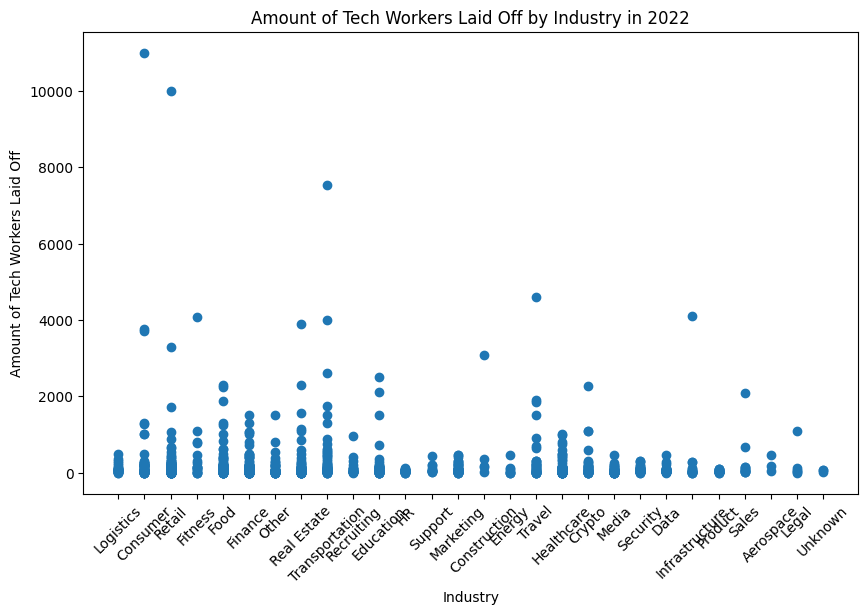

In [63]:
# plot lay off counts based on industry
plt.figure(figsize=(10,6))
plt.scatter(data["Industry"],data["Laid_Off_Count"]);
plt.xticks(rotation= 45)
plt.xlabel("Industry")
plt.ylabel("Amount of Tech Workers Laid Off")
plt.title("Amount of Tech Workers Laid Off by Industry in 2022")
plt.show()

#### This plot is quite interesting. Because every company's size is different, most companies' layoff count are located around 0 - 2000 people. It is much harder to distinguish if the industry actually has any effect on layoff count with this graph. Also, two companies have an astonishingly high lay off count in the consumer and retail industry. As we saw before, these two companies are Meta and Amazon.

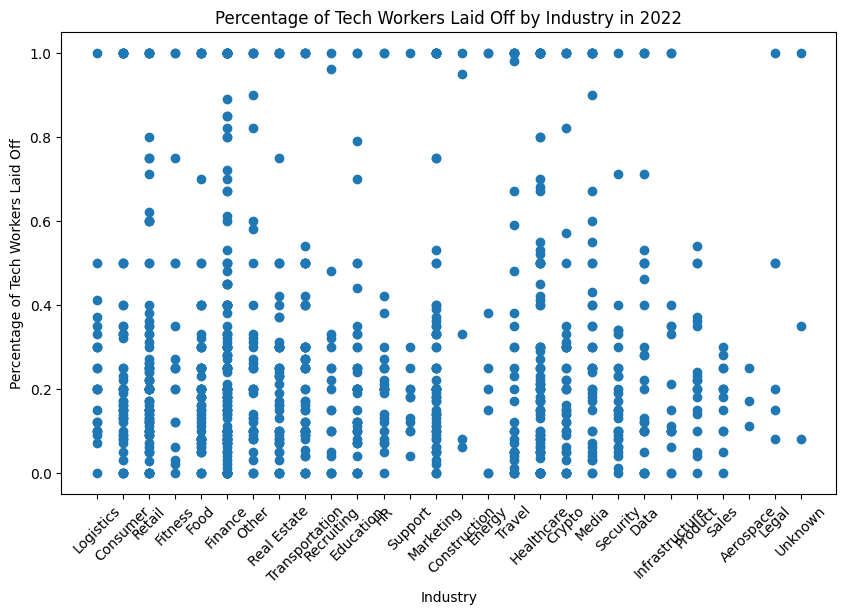

In [64]:
# plot percentages based off industry
plt.figure(figsize=(10,6))
plt.scatter(data["Industry"],data["Percentage"]);
plt.xticks(rotation= 45)
plt.xlabel("Industry")
plt.ylabel("Percentage of Tech Workers Laid Off")
plt.title("Percentage of Tech Workers Laid Off by Industry in 2022")
plt.show()

#### Regarding percentages, this scatter plot is slightly more dispersed; however, it is still difficult to locate a correlation qualitively. Interestingly, we see many companies with a 1.0 lay off percentages, so it seems bankruptcies are not niche to the type of industry. We also see higher variance within the finance and healthcare sector.

#### Since outliers are causing our plot to become stretched, let's [standardize](https://www.sciencedirect.com/topics/computer-science/data-standardization) our data and repeat these scatter plots. Standardization scales our data upon the mean and standard deviation, which effectively reduces the impact of outliers.

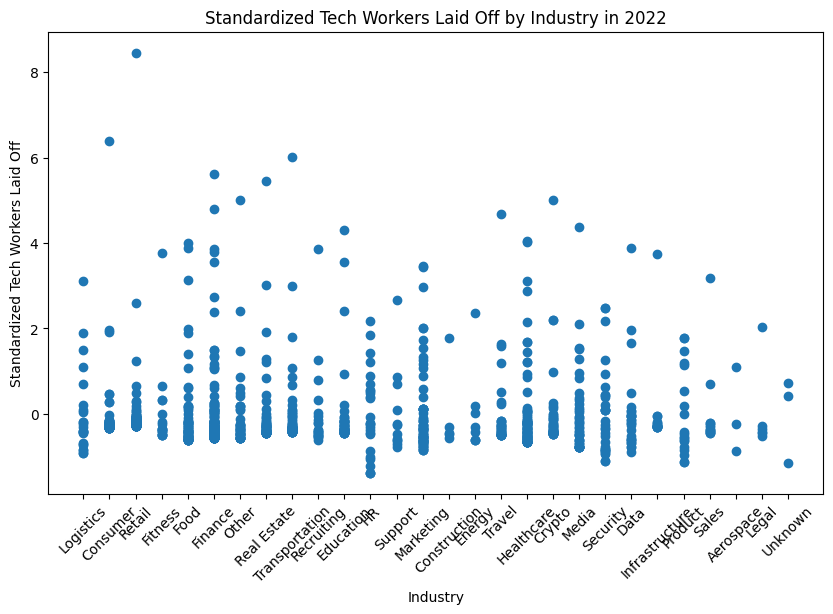

In [65]:
# standardize our lay off counts
stdLayoff = []
avg_layoff = data.groupby("Industry")["Laid_Off_Count"].mean()
std_dev = data.groupby("Industry")["Laid_Off_Count"].std()
for i in range(len(data["Laid_Off_Count"])):
    stdLayoff.append((data["Laid_Off_Count"][i] - avg_layoff[data["Industry"][i]]) / std_dev[data["Industry"][i]])
    
# create a new data frame with standardizations, and plot it based on industry
data["stdLayoff"] = stdLayoff
plt.figure(figsize=(10,6))
plt.scatter(data["Industry"],data["stdLayoff"]);
plt.xticks(rotation= 45)
plt.xlabel("Industry")
plt.ylabel("Standardized Tech Workers Laid Off")
plt.title("Standardized Tech Workers Laid Off by Industry in 2022")
plt.show()

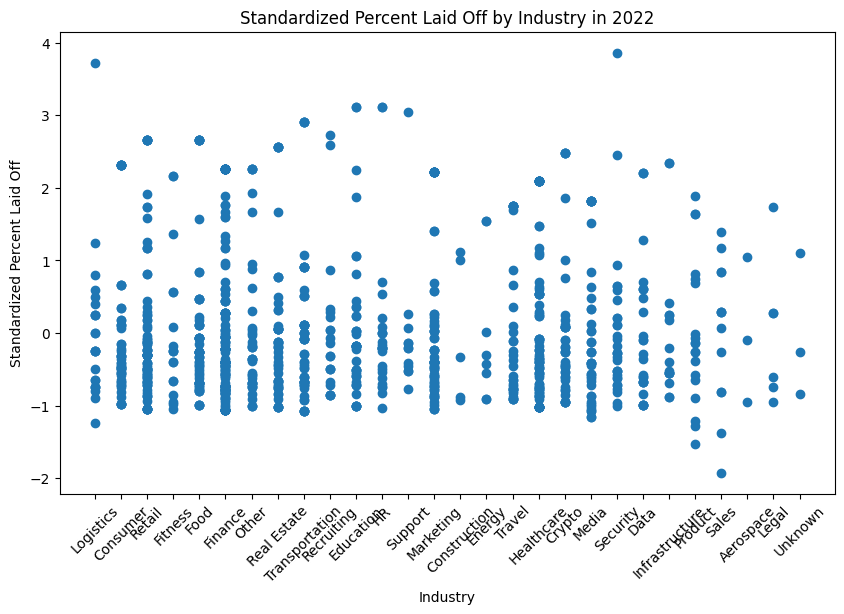

In [66]:
# standardize our percentages
stdPercentage = []
avg_Percentage = data.groupby("Industry")["Percentage"].mean()
std_dev = data.groupby("Industry")["Percentage"].std()
for i in range(len(data["Percentage"])):
    stdPercentage.append((data["Percentage"][i] - avg_Percentage[data["Industry"][i]]) / std_dev[data["Industry"][i]])
    
# create a new data frame with standardizations, and plot it based on industry
data["stdPercentage"] = stdPercentage
plt.figure(figsize=(10,6))
plt.scatter(data["Industry"],data["stdPercentage"]);
plt.xticks(rotation= 45)
plt.xlabel("Industry")
plt.ylabel("Standardized Percent Laid Off")
plt.title("Standardized Percent Laid Off by Industry in 2022")
plt.show()

#### After standardizing both scatterplots, we gain slightly more information. In the standardized lay off plot, we see lower standardized lay offs in the logistics, HR, and product sectors. Unfortunately, the standardized percentage plot shows little new information. It looks very similar to the original percentage plot.  

#### Overall, we must move onto a distribution plot such as a violin plot. A violin plot visualizes where most of the data is as well as showing where the mean is. Because we saw little information regarding the percentages, we will refrain from creating violin plots of percentages.

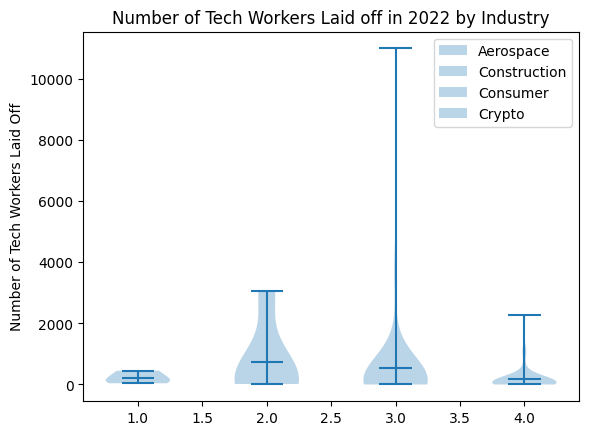

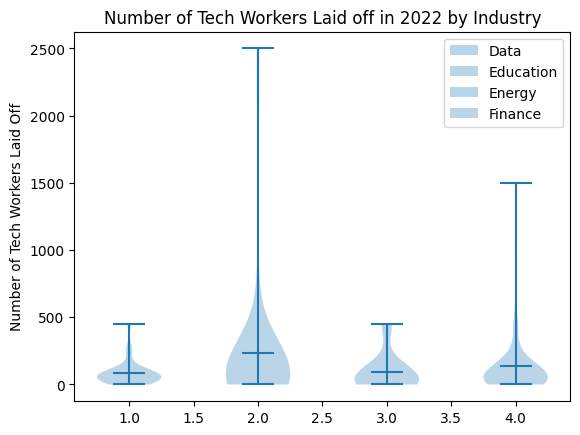

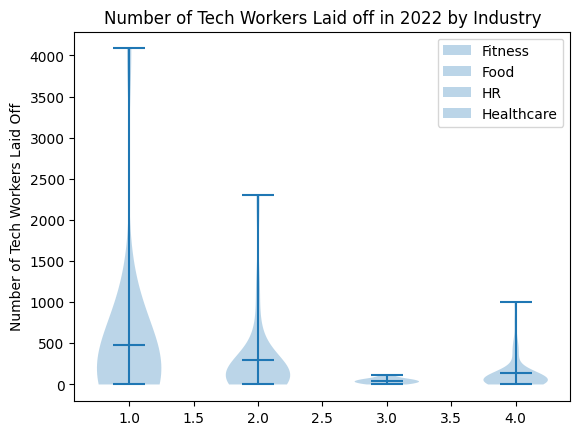

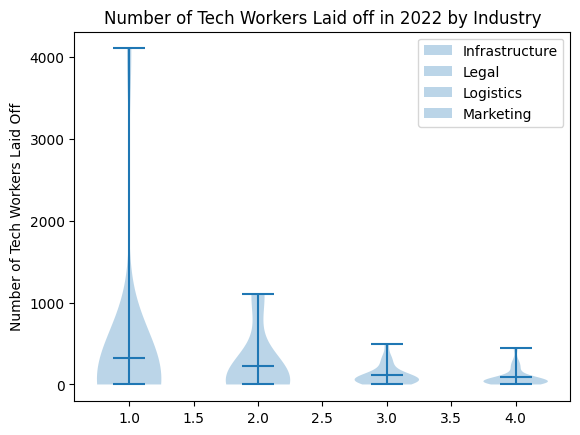

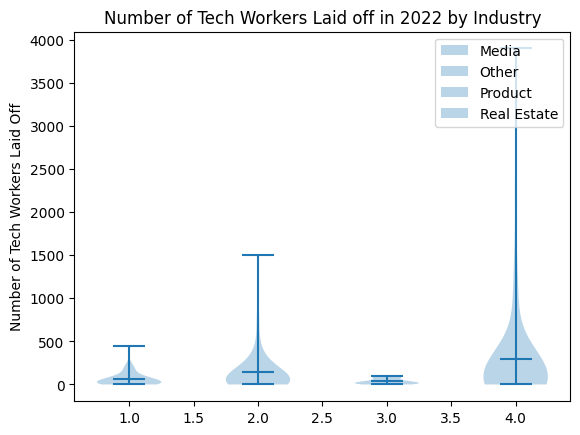

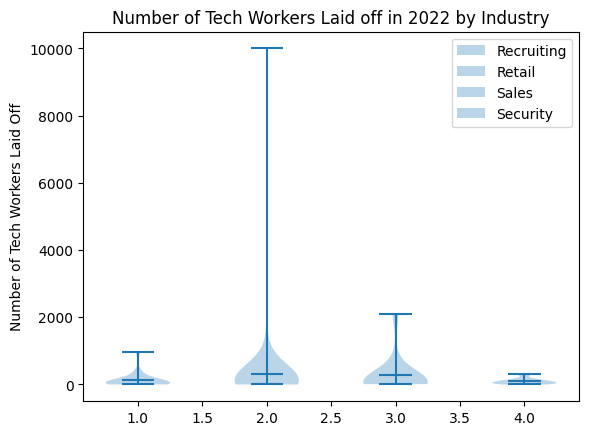

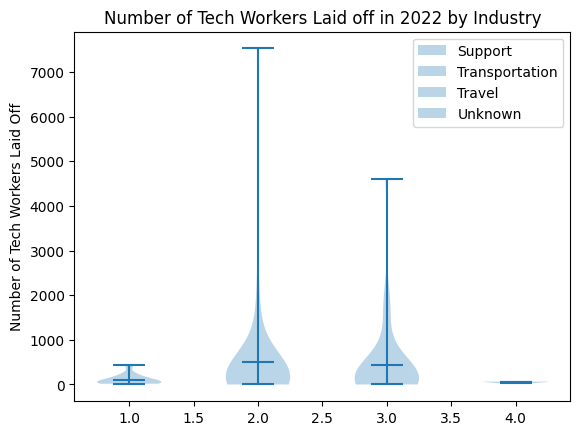

In [67]:
layedoff_by_industry = []
labels = [['Aerospace','Construction','Consumer','Crypto'],['Data','Education','Energy','Finance'],
          ['Fitness','Food','HR','Healthcare'],['Infrastructure','Legal','Logistics','Marketing'],
          ['Media','Other','Product','Real Estate'], ['Recruiting','Retail','Sales','Security'],
          ['Support','Transportation','Travel','Unknown']]
for i in range(7):
    layedoff_by_industry.append([])
count = 0
industry = data.groupby(by = data["Industry"])

# create a violin plot of lay off counts based on industry, make sure to fit 4 plots onto each graph
for i in industry:
    layedoff_by_industry[int(count/4)].append((i[1]["Laid_Off_Count"]))
    count += 1
    if count % 4 == 0:
        fig, ax = plt.subplots()
        ax.violinplot(layedoff_by_industry[int(count/4)-1],showmeans=True)
        ax.legend(labels[int(count/4)-1])
        fig.show()
        ax.set_ylabel("Number of Tech Workers Laid Off")
        ax.set_title("Number of Tech Workers Laid off in 2022 by Industry")

#### These set of violin plots reveal much more information about how the data is distributed. Overall all the violin plots have a thicker lower half which means most of the data is below the mean. This makes sense as a company's size affects the total number of layoffs significantly. Thus, the large companies like Meta, Amazon, and Uber will drive the mean up. Regarding the means, we see lower means in the data, energy, finance, healthcare, media, , security, and logistics sectors. 

### Overall, regarding industry, the industries that repeatedly appear in our analysis are HR, product, media, healthcare, infrastructure, and logistics. These are the best industries to join in regards to layoffs.

## STAGE

#### We will now move onto stage and analyze the affect of stage on lay off percentage. We will not be utilizing lay off counts for this part of the analysis because a smaller company will obviously lay off less employees than a large company. It is first necessary to explain what stage implies. All companies are not the same; Some are larger in size and other are smaller. Some are open to the public meaning you can purchase a portion of the company while others are completely private. Thus, stage refers to the type of company. Seed companies represent startups. Series companies mean they have risen from a seed company and have a set amount of assets/investment in the company. So, series A means low assets since it just rose from a seed, while series E companies have very large amounts of assets/investments. Next, a private equity company is a company in partner with a private equity firm. The firms' goal is the restructure the company towards success.  An IPO company is a company large enough that it can go public where citizens can purchase a percentage of the company. Lastly, an acquired company refers to a company that has been purchased by another company. Now that we understand the different stages, let's begin by grouping each stage to its corresponding percentage means.

In [68]:
# group data frame by the percentage mean based on stages, sort dataframe
stagePercentage = pd.DataFrame(data.groupby('Stage')['Percentage'].mean())
stagePercentage = stagePercentage.sort_values(by='Percentage', ascending = True)
stagePercentage.head()

,Percentage
Stage,
Series I,0.230000
Series A,0.232414
Series G,0.243333
Acquired,0.262369
Series F,0.272083


#### The top 5 stages with the lowest median lay off percentages are Series I, Series A, Series G, Acquired, and Series F. Let's visualize our data. We believe the best type of graph here would be a scatter plot based on the lay off percentage. 

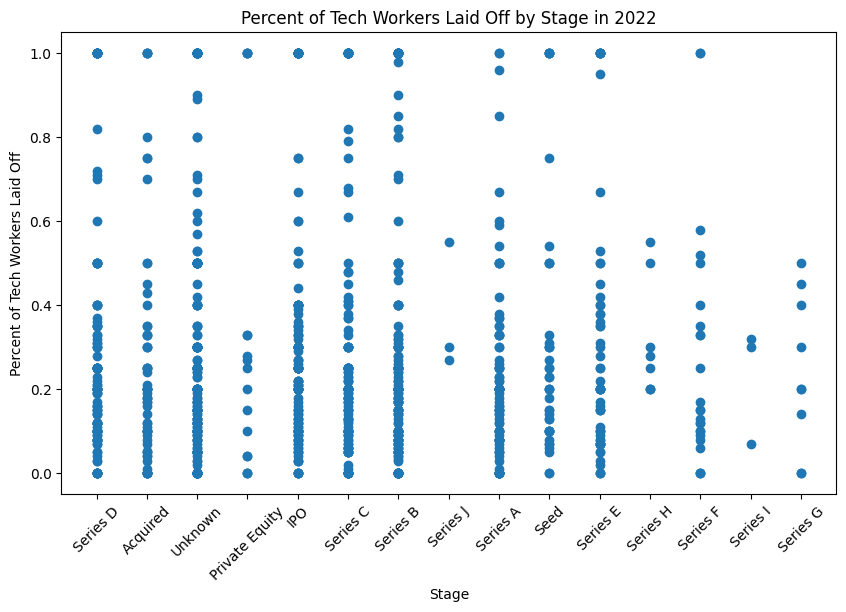

In [69]:
# create a scatter plot of percent based on stage
plt.figure(figsize=(10,6))
plt.scatter(data["Stage"], data["Percentage"])
plt.xticks(rotation= 45)
plt.xlabel("Stage")
plt.ylabel("Percent of Tech Workers Laid Off")
plt.title("Percent of Tech Workers Laid Off by Stage in 2022")
plt.show()

#### It is difficult to extract relevant data through a scatter plot in this case. There is too much data to visually see how the distribution is for each stage. We will move onto a box plot to better visualize the data.

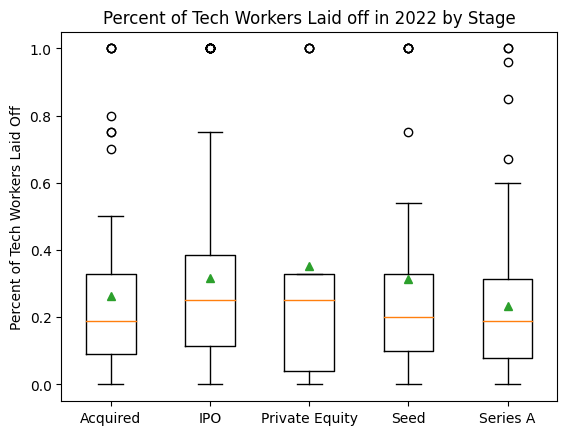

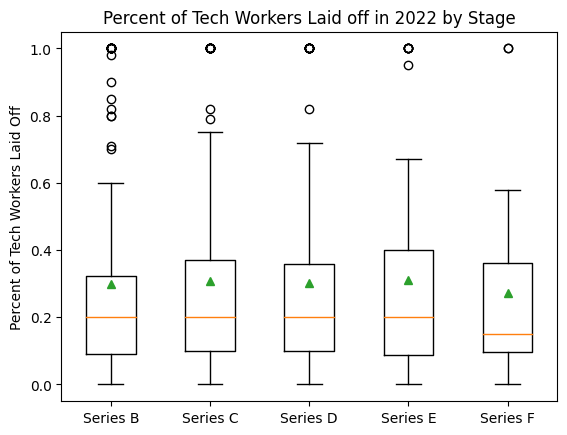

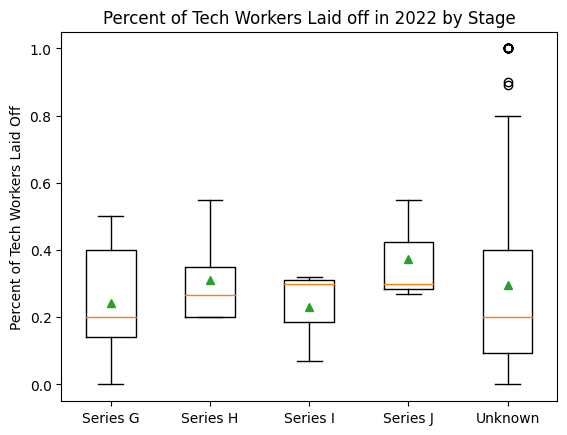

In [70]:
layedoff_by_stage = []
labels = [['Acquired','IPO','Private Equity','Seed','Series A'], ['Series B','Series C','Series D','Series E','Series F'],
         ['Series G','Series H','Series I','Series J','Unknown']]
for i in range(3):
    layedoff_by_stage.append([])
count = 0
stage = data.groupby(by = data["Stage"])

# create a box plot of lay off counts based on stage, make sure to fit 5 plots onto each graph
for i in stage:
    layedoff_by_stage[int(count/5)].append((i[1]["Percentage"]))
    count += 1
    if count % 5 == 0:
        fig, ax = plt.subplots()
        ax.boxplot(layedoff_by_stage[int(count/5)-1], labels = labels[int(count/5)-1], showmeans = True)
        fig.show()
        ax.set_ylabel("Percent of Tech Workers Laid Off")
        ax.set_title("Percent of Tech Workers Laid off in 2022 by Stage")

#### These boxplots give much more insight into the layoff percentages by stage. The orange line indicates median and the green arrow indicates mean. Points above the boxplot reveal outliers. Thus, notice how boxplots with several points have a larger distance between the mean and median. Overall, the plots with the lowest median is the series F plot. Many other plots share the same median of around 0.2. Almost all plots have a large 4th quartile. This is most likely due to if a company is within the 4th quartile, they are near bankrupt thus they would release a large amount of their workforce, driving the quartile up. 

#### We mentioned before that it seemed many companies who went bankrupt were early companies either in the seed or series A stage. Intuitively, this makes sense but lets make sure. We will be creating a bar plot of the total bankrupt companies by stage.

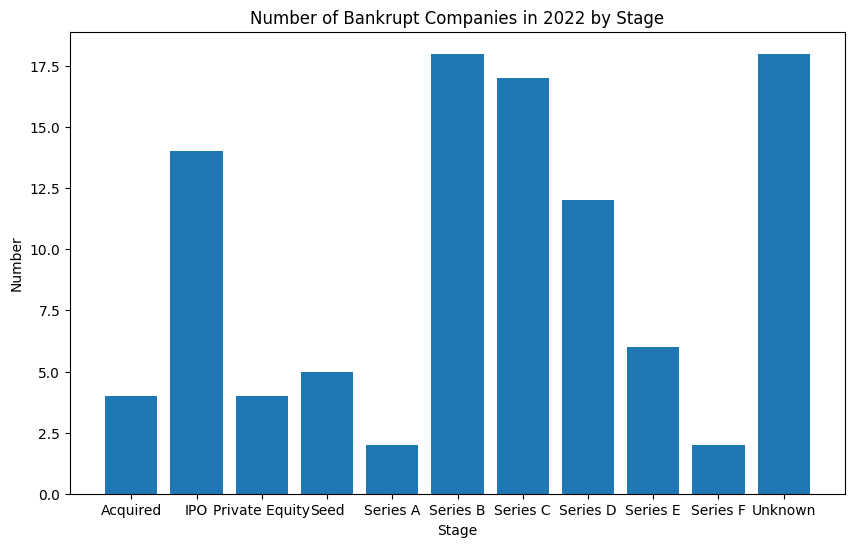

In [71]:
# create a new data frame where all percentages have a 1.0 value
bankrupt = data[data["Percentage"] == 1.0]
bankrupt = bankrupt.sort_values(by = "Stage")
stages = bankrupt["Stage"].unique()

# find total percentages with a 1.0 value based on industry and create a bar plot based on industry
bankrupt = pd.DataFrame(bankrupt.groupby('Stage')["Percentage"].count())
plt.figure(figsize=(10,6))
plt.bar(stages,bankrupt["Percentage"]);
plt.title("Number of Bankrupt Companies in 2022 by Stage")
plt.xlabel("Stage")
plt.ylabel("Number")
plt.show()

#### Aha!. It looks like there isn't a very strong correlation with startups and bankruptices. 5 notable seed companies went bankrupt, and 2 series A companies went bankrupt. Meanwhile, IPO had 14 companies go bankrupt. We can note that series B and C had high bankruptcies, but they are no longer considered startups. 

### Overall, it seems that stage has little correlation to the percentage of workers fired. Many of these boxplots look very similar, but if we were to choose the best stage to join it would be a series F or a series I company. Also, we noted that in 2022 many companies who went bankrupt were not startups.

## DATE

#### Now, let's see if there were more or less lay offs depending on the date. We will begin by grouping the lay off totals by date and creating a line plot with months as the x-axis and layoffs as the y-axis. A problem does arise where the date are specific dates. Thus, we will have to parse the date column and assign it to a month. 

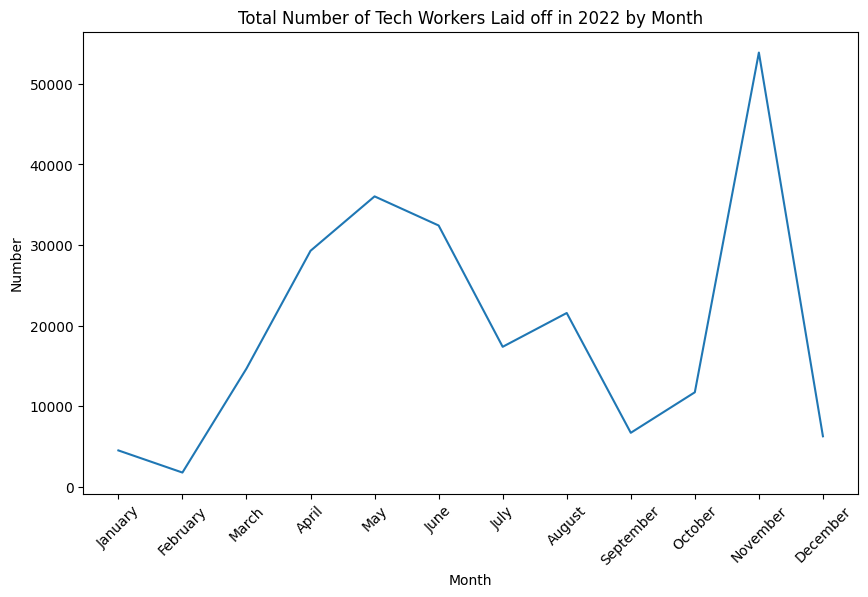

In [72]:
dates = []

# split up date and manually process each month into its name
for i in range(len(data["Date"])):
    split = data["Date"][i].split("-")
    if split[1] == "01":
        dates.append("January")
    elif split[1] == "02":
        dates.append("February")
    elif split[1] == "03":
        dates.append("March")
    elif split[1] == "04":
        dates.append("April")
    elif split[1] == "05":
        dates.append("May")
    elif split[1] == "06":
        dates.append("June")
    elif split[1] == "07":
        dates.append("July")
    elif split[1] == "08":
        dates.append("August")
    elif split[1] == "09":
        dates.append("September")
    elif split[1] == "10":
        dates.append("October")
    elif split[1] == "11":
        dates.append("November")
    elif split[1] == "12":
        dates.append("December")
data["Month"] = dates

# find total lay off counts by month, create a line plot with month as x-axis and lay off count as y-axis
sums = pd.DataFrame(data.groupby('Month')["Laid_Off_Count"].sum())
xAxis = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
yAxis = [sums.loc["January"][0], sums.loc["February"][0], sums.loc["March"][0], sums.loc["April"][0], sums.loc["May"][0], 
         sums.loc["June"][0], sums.loc["July"][0], sums.loc["August"][0], sums.loc["September"][0], sums.loc["October"][0], 
         sums.loc["November"][0], sums.loc["December"][0]]
plt.figure(figsize=(10,6))
plt.plot(xAxis,yAxis);
plt.title("Total Number of Tech Workers Laid off in 2022 by Month")
plt.xticks(rotation= 45)
plt.xlabel("Month")
plt.ylabel("Number")
plt.show()

#### This line plot is very interesting. We see that from February to May, there seems to be a positive linear correlation between month and lay off count. it significantly dips after this time. From the end of May to September we see steep descent. Finally, from October to November we see the largest spike in 2022. In this time more than 40,000 employees were laid off. We cannot account for December since this Analysis was curated during the 2nd week of December. However, it is very important to see the lay off numbers at the end of December. Possibly, we can see even more layoffs.  

#### Let's see if we can create linear regressions on the line plot from the months February to May and May to September. We initially thought to create a linear regression on the entire graph, but that would not make sense. There is no clear linear correlation on all the months, but there is a positive linear correlation between February to May and May to September.

In [73]:
# fit a linear regression model onto the specific months stated, perform an f-regression test
months = np.array([1,2,3,4])
months = months.reshape(-1,1)
reg1 = LinearRegression().fit(months, [sums.loc["February"][0], sums.loc["March"][0], sums.loc["April"][0], sums.loc["May"][0]])
print('Coefficient: %f' % reg1.coef_)
data1 = pd.DataFrame([sums.loc["February"][0], sums.loc["March"][0], sums.loc["April"][0], sums.loc["May"][0]], [1,2,3,4])
freg = f_regression(months, data1[0])
p=freg[1]
print("P-value: %f" % p)

Coefficient: 11748.100000
P-value: 0.010034


#### We have a coefficient or slope of 11,748 between the months of February and May. That means every month during this time period, there was an average increase of 11,748 employees laid off every month. 

In [74]:
# fit a linear regression model onto the specific months stated, perform an f-regression test
months = np.array([1,2,3,4,5])
months = months.reshape(-1,1)
reg2 = LinearRegression().fit(months, [sums.loc["May"][0], sums.loc["June"][0], sums.loc["July"][0], sums.loc["August"][0], sums.loc["September"][0]])
print('Coefficient: %f' % reg2.coef_)
data2 = pd.DataFrame([sums.loc["May"][0], sums.loc["June"][0], sums.loc["July"][0], sums.loc["August"][0], sums.loc["September"][0]], [1,2,3,4,5])
freg = f_regression(months, data2[0])
p=freg[1]
print("P-value: %f" % p)

Coefficient: -6956.900000
P-value: 0.021625


#### We have a coefficient of -6959 between the months of May and September. That means during this time period, there was an average decrease of 6959 employees getting laid off. This is a good thing.

### Hypothesis Testing
#### Along with our linear regression, we should check how strong the correlation is. This is where we can utilize hypothesis testing to check the validity of our slopes. On both regression models, we ran a F regression test which returns a p-value as the second return value. Thus, we still state for both models that our null hypothesis will be there is no correlation between month and lay off count. The alternate hypothesis will state that there is a correlation between month and lay off count. We will set our threshold at 0.05 since that is the standard. Because the [p-value](https://www.scribbr.com/statistics/p-value/) is below the 0.05 threshold, we reject both null hypotheses and state their is a correlation during these times. After researching the U.S. market, according to [simplywall](https://simplywall.st/article/us-markets-worst-day-in-2022), the S&P's worst top worst days were during the months of April, June, and July. This supports our first coefficient.

### Overall, the date shows where lay offs were the greatest. As we saw in the graph, we saw peaks in both May and November. We also found a positive linear correlation from the months February to May and a negative linear correlation from May to September. This data supports the idea that an individual was safer at his/her occupation from May to September.

## LOCATION

### Yes, you guessed it. The last thing that we will look at in-depth is Location. We will attempt to answer the following question: Does location give us any indication on layoffs? Based on the answer to the previous question, we will then take a closer look at the best and worst locations in terms of layoff.  

#### In the code section below we will be using the geopy python client service. In particular, the Noninatim geolocation service to get the coordinate data (longitude, latitude) for each location represented in the dataset. You will see why we need this in the following sections. 

In [75]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='jwendlan')
unique_locs = np.unique(data['Location'].to_numpy()) # getting unique locations, to avoid duplication
locations = {}
bad = []
for loc in unique_locs: 
    l_info = geolocator.geocode(loc)
    if l_info != None: 
        locations[loc] = l_info
    else: 
        bad.append(loc)# if geocode has a problem with the location, track it
bad

['Ferdericton', 'Shenzen']

#### As you probably already know, no dataset is perfect. Here we print out all the bad locations. It looks like Fredericton and Shenzhen were mispelled. We must account for this. 

#### In addition, we will now create a new dataframe using the coordinate data we generated above. The new dataframe, location_df, contains the coordinate data for each row in the dataset. 

In [76]:
locations['Ferdericton'] = geolocator.geocode('Fredericton') #correcting bad data
locations['Shenzen'] = geolocator.geocode('Shenzhen')
location_df = data.copy()

location_df['Latitude'] = 0.0
location_df['Longitude'] = 0.0
for ind in location_df.index: 
    loc = locations[location_df['Location'][ind]] #getting the coordinates 
    location_df['Latitude'][ind] = loc.latitude
    location_df['Longitude'][ind] = loc.longitude
location_df.head()

,Company,Location,Industry,Laid_Off_Count,Percentage,Date,Stage,Country,stdLayoff,stdPercentage,Month,Latitude,Longitude
0,uShip,Austin,Logistics,65.0,0.09,2020-03-31,Series D,United States,-0.393663,-0.797461,March,30.271129,-97.743700
1,iRobot,Boston,Consumer,140.0,0.08,2022-08-05,Acquired,United States,-0.239997,-0.713525,August,42.355433,-71.060511
2,iPrice Group,Kuala Lumpur,Retail,50.0,0.17,2022-06-08,Unknown,Malaysia,-0.236008,-0.417836,June,3.151696,101.694237
3,iFit,Logan,Fitness,300.0,0.27,2022-11-14,Private Equity,United States,-0.188510,-0.180390,November,40.107509,-89.376854
4,ezCater,Boston,Food,400.0,0.20,2020-04-07,Series D,United States,0.193293,-0.255543,April,42.355433,-71.060511


#### Now that we got that out of the way, lets plot! We will be using the geopandas, an open-source python library, that will allow us to now use our coordinate data to plot the layoffs that occured around the globe in the year, 2022. 

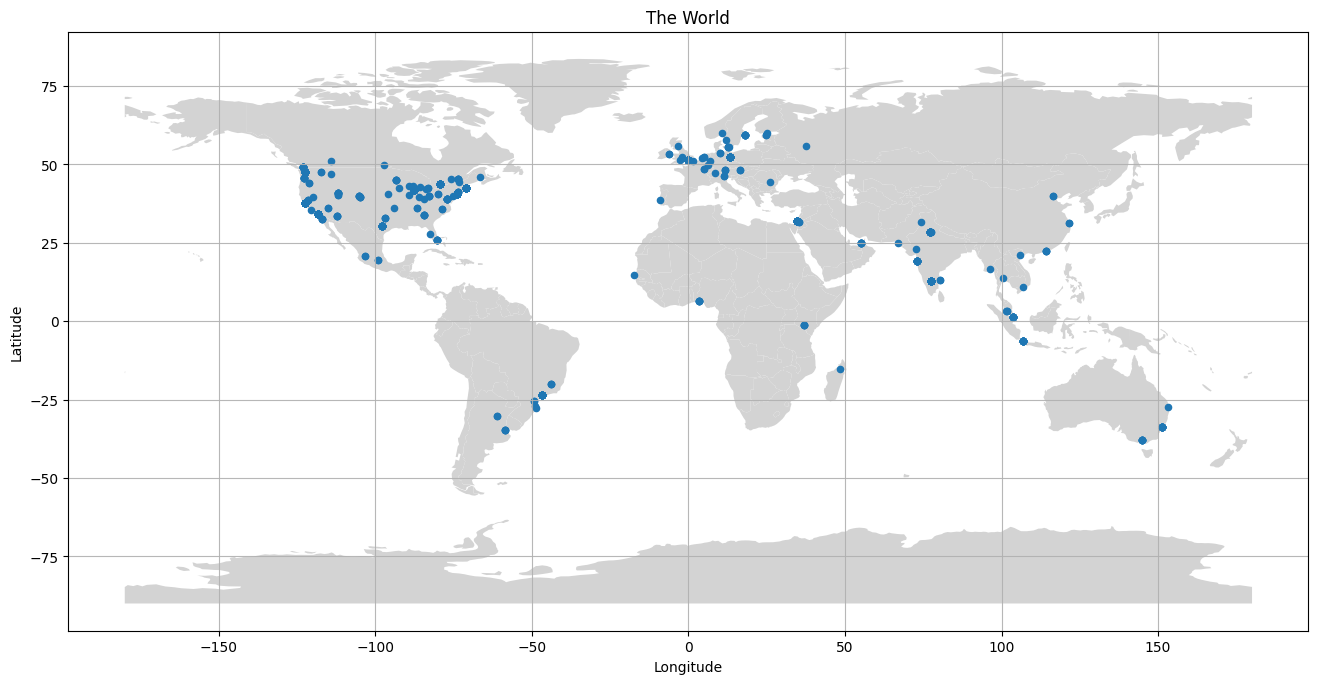

In [77]:
import geopandas as gpd 
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(16,10))
countries.plot(color='lightgrey', ax=ax)
location_df.plot(x='Longitude', y='Latitude', kind='scatter', ax=ax, title='The World')
ax.grid(b=True, alpha=0.9)
plt.show()

#### It looks like most layoffs occured in the United States of America with some clumping in popular European countries as well. For the sake of analysis, lets dive deeper and look at the United States more closely. It is important to note that we are looking specifically at the layoff distribution in the above graph. This graph does not take into account the number of laid off workers per company, just where the layoffs happened. 

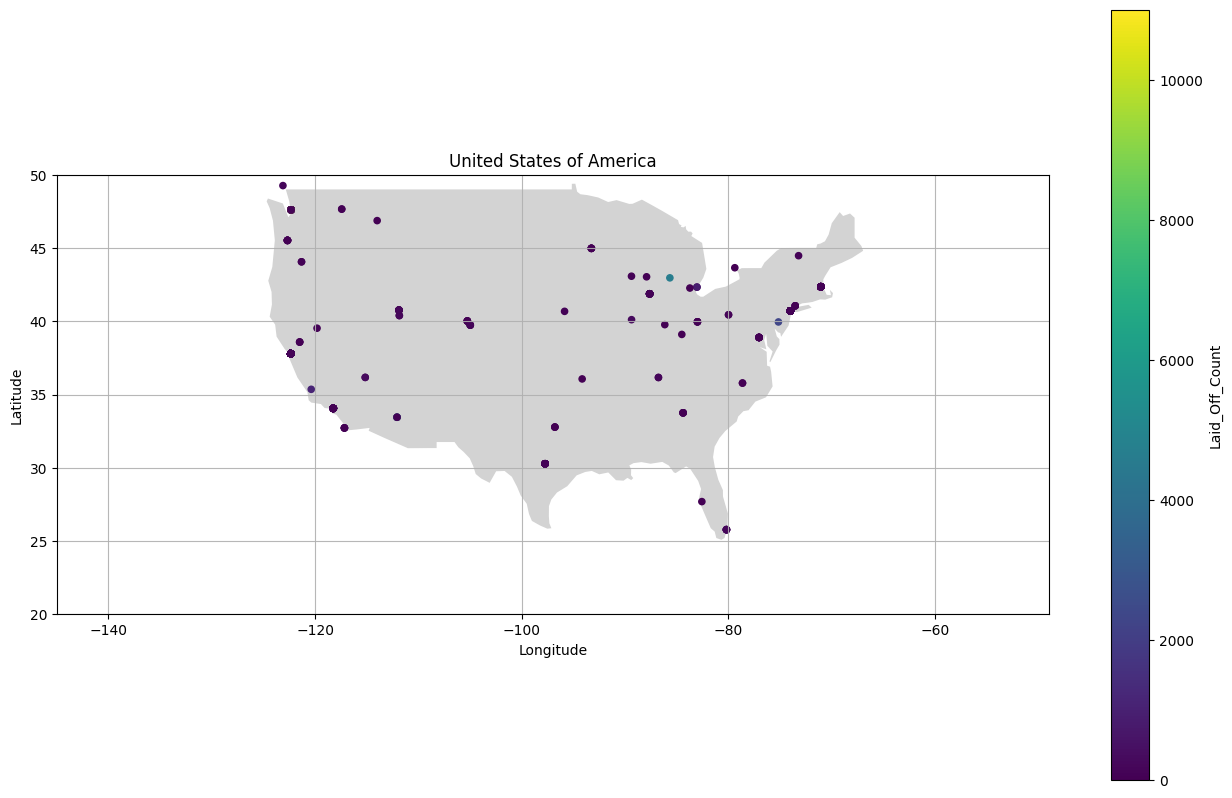

In [78]:
# create a heat geo-plot based on lay off count
fig, ax = plt.subplots(figsize=(16,10))
countries[countries['name'] == 'United States of America'].plot(color='lightgrey', ax=ax)
location_df[location_df['Country'] == 'United States'].plot(x='Longitude', y='Latitude',c='Laid_Off_Count', kind='scatter', ax=ax, title='United States of America')
ax.grid(b=True, alpha=0.9)
x_min, x_max ,y_min ,y_max = -145, -49, 20, 50
plt.axis([x_min, x_max, y_min, y_max]) # To zoom in and really isolate the USA
plt.show()

#### The layoffs look pretty spread out. There is a gap where the Midwest and West meet, nonetheless. Perhaps this is a great place to work, however prior knowledge tells us that the majority of tech companies are not located in that area. The upper right of the Midwest looks to have some clumping, as well as both the state of California and the smaller Northeast states. We can see that the highest layoff count is a turquoise dot in what I believe to be the state of Michigan.

#### Since lay off count does not show much, lets retry our geo-plot based on percentages.

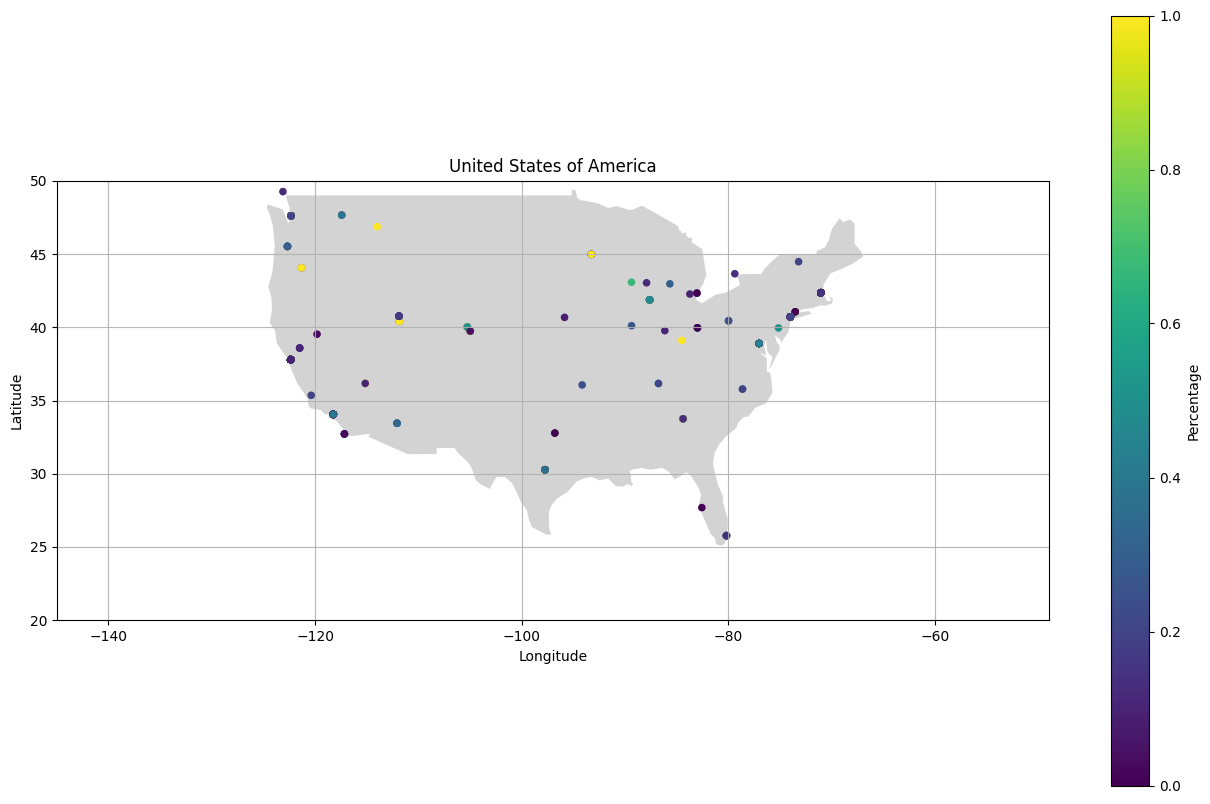

In [79]:
# create a heat geo-plot based on percentage
fig, ax = plt.subplots(figsize=(16,10))
countries[countries['name'] == 'United States of America'].plot(color='lightgrey', ax=ax)
location_df[location_df['Country'] == 'United States'].plot(x='Longitude', y='Latitude',c='Percentage', kind='scatter', ax=ax, title='United States of America')
ax.grid(b=True, alpha=0.9)
x_min, x_max ,y_min ,y_max = -145, -49, 20, 50
plt.axis([x_min, x_max, y_min, y_max]) # To zoom in and really isolate the USA
plt.show()

#### Ok we do learn a little more about tech layoffs with this geo-plot. We see a clumping of higher percentage layoffs with longitudes ranging from [-90,-80] and latitudes [38,44]. This small bubble has a concentrated lay off percentage. Also, note how in the lay off count geo-plot, the only blue-green point is also in the same location. Although it is difficult to distinguish if the location has an effect on why this area had higher lay off percentages, it is advisable to watch out. 

### Overall, the global graph provides more insight then the smaller, USA graph. We were able to determine where the layoffs were occuring globally; however, as you zoom further in, at least in the USA case, it becomes harder to make conclusive statements from the graph. In conclusion, at least from what we saw, location is correlated to the layoffs but one does need to account for the distribution of tech companies across the globe and the USA to effectively justify our inferences. 

## CONCLUSION

### Overall, we learned quite a bit in this tutorial. First we learned the proper steps for data cleaning. Not every dataset is perfect (especially ours), so we have to clean the data so we can properly utilize it. For example, in the location plot, the data had misspelled locations, so many changes must be made. Next, we made intial explorations on our data which simply showed the companies with the highest lay off counts and percentages. Afterwards, we moved on to finding correlations between industry, stage, date, and location to lay off count/percentage. In indsutry, we created scatter plots, standardized our data, and made a violin plot. We concluded the safest industries to join were HR, product, media, healthcare, infrastructure, and logistics. Next we looked for any correlation between the stage of a company and lay off statistics. We looked at the overall median percentages and made violin plots. In the end, we found little data supporting the idea that the stage of a company affects lay off counts. Naturally, this makes sense because every business' success is unique; stage should not affect a business' success. In stage, we also noted that the stage of a company has little correlation to whether it goes bankrupt. Afterwards, we moved onto date. We created a line graph with total lay off numbers according the month of 2022. We noticed what appeared to be correlations depending on the month. We validated this by creating linear regressions models. We then validated those models with hypothesis tests. Ultimately, we found a positive correlation between the months February to May and a negative correlation between the months May to September. Lastly, we examined location. First we created a large geographic plot of the world and plotted all the points of the companies. Afterwards, we honed in on the U.S. and looked at where the highest lay off number/percentages resided. We actually see a clump of high lay off statistics between the Midwest and East Coast. Thus, we learned a lot about lay offs in 2022. Along the way, we learned many skills such as plotting, drawing hypothesis, and supporting them. We also learned many pandas skills such as utilizing geopandas, matplotlib, and regression models. Most importantly, we learned how to be a data scientist.